# High dimensional visualization on NFWBS_PUF_2016_data

Visualizing high dimensional data is a difficult problem and this notebook will help you apply t-SNE on your data. Although t-SNE is mathematically more complicated than other visualizations, it is also more powerful.

The general idea for projecting high dimensional data into 2 dimensions is to preserve the original relative distances between points, but in the plane.

A simple method called multidimensional scaling does the equivalent of putting springs between each of the points, whose strength is inversely proportional to the original distance. This will pull points together in the plane, and recover some of the original topology. However this method is not very efficient, and often falls into a local minimum that does not accurately represent the original topology.

Another simple method is Sammon's mapping, in which we try harder to preserve the distances between nearby points than between those which are far apart. If two points are twice as close in the original space as two others, it is twice as important to maintain the distance between them. This method is better at revealing local, small-scale ordering.

However, t-SNE does a very good job at revealing both the small scale and global topology of your high-dimensional data, and this is why we favor it. However, be aware that it can be harder to use correctly, so make sure to read the following instructions.

## A bit of theory

The t-SNE algorithm comprises two main stages.
First, t-SNE constructs a probability distribution over pairs of your high-dimensional points, so that similar ones have a high probability of being picked, whilst dissimilar points have an extremely small probability of being picked.

Second, t-SNE defines another probability distribution over the points in the two-dimensional plane, and it minimizes the Kullback–Leibler divergence (a measure of the difference between two probability distributions) between the high-dimensional and two-dimensional distributions, with respect to the locations of the points in the map.

More details at https://lvdmaaten.github.io/tsne/

## Recommendation

Before applying t-SNE, it is highly recommended to use another dimensionality reduction method (e.g. PCA) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high.

More details at http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In this notebook, we will display t-SNE results for both the raw data, the rescaled data and data on which PCA was applied.

## Outline

* [Setup and loading the data](#setup)
* [Preprocessing of the data](#preprocessing)
* [t-Distributed Stochastic Neighbor Embedding (aka t-SNE)](#tsne)

<center><strong>Select Cell > Run All to execute the whole analysis</strong></center>

## Setup and dataset loading <a id="setup" /> 

First of all, let's load the libraries that we'll use

In [42]:
%pylab inline
import dataiku                               # Access to Dataiku datasets
import pandas as pd, numpy as np             # Data manipulation
from sklearn.decomposition import PCA        # PCA capability
from sklearn.manifold import TSNE            # Import TSNE capability from scikit
from matplotlib import pyplot as plt         # Graphing
from collections import defaultdict, Counter # Utils
import warnings                              # Disable some warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

Populating the interactive namespace from numpy and matplotlib


The first thing we do is now to load the dataset and put aside the three main types of columns:

* Numerics
* Categorical
* Dates

Since analyzing PCA requires to have the data in memory, we are only going to load a sample of the data. Modify the following cell to change the size of the sample.

By default, date features are not kept. Modify the following cell to change that.

Also, by default, categorical columns are not included in the t-SNE data (preventing the creation of very sparse data). Modify the following cell to enable dummification.
We also use a categorical column for coloring if possible.

In [43]:
# Change sample size here
dataset_limit = 10000
# Toggle to keep dates in your dataset
keep_dates = False
# Toggle to dummify categorical features
dummify_categories = False

Load a DSS dataset as a Pandas dataframe

In [44]:
# Take a handle on the dataset
mydataset = dataiku.Dataset("NFWBS_PUF_2016_data")

# Load the first lines.
# You can also load random samples, limit yourself to some columns, or only load
# data matching some filters.
#
# Please refer to the Dataiku Python API documentation for more information
df = mydataset.get_dataframe(limit = dataset_limit)

df_orig = df.copy()

# Get the column names
numerical_columns = list(df.select_dtypes(include=[np.number]).columns)
categorical_columns = list(df.select_dtypes(include=[object]).columns)
date_columns = list(df.select_dtypes(include=['<M8[ns]']).columns)

# Print a quick summary of what we just loaded
print "Loaded dataset"
print "   Rows: %s" % df.shape[0]
print "   Columns: %s (%s num, %s cat, %s date)" % (df.shape[1], 
                                                    len(numerical_columns), len(categorical_columns),
                                                    len(date_columns))

Loaded dataset
   Rows: 6394
   Columns: 217 (217 num, 0 cat, 0 date)


## Preprocessing of the data <a id="preprocessing" />

### Handle dates

Keep the dates as features if requested by the user

In [45]:
columns_to_drop = []

if keep_dates:
    df[date_columns] = df[date_columns].astype(int)*1e-9
else:
    columns_to_drop.extend(date_columns)

### Categorical coloring
You can choose which color to use here, or we will select one automatically.

In [46]:
import matplotlib.cm as cm
import matplotlib.patches as mpatches

def find_color_column(df, categorical_columns):
    color_column = []
    if len(categorical_columns) == 0:
        return color_column

    else:
        color_column = categorical_columns[0]
        
        for col in categorical_columns:
            if df[col].nunique() > 3 and df[col].nunique() < 10:
                color_column = col
                break;
    return color_column

def generate_color_replacements(color_column):
    colors = cm.rainbow(np.linspace(0, 1, df[color_column].nunique()))
    return {key: value for (key, value) in  zip(df[color_column].unique().tolist(), colors)}

In [47]:
color_column = find_color_column(df, categorical_columns)

Change the value here to use a custom column for coloring your t-SNE.

In [48]:
#color_column = 'my_color_column'
print "We will use column '{}' for coloring.".format(color_column)

We will use column '[]' for coloring.


We generate the list of colors and the legend

In [49]:
patches = []

if color_column:
    cat_replacements = generate_color_replacements(color_column)    
    coloring_list = df[color_column].map(cat_replacements)

    for couple in cat_replacements:
        patch = mpatches.Patch(color=cat_replacements[couple], label=couple.decode('utf8'))
        patches.append(patch)
else:
    coloring_list = np.zeros(df.shape[0])

### Additional preparation

Get rid of the columns that contain too many unique values

In [50]:
DROP_LIMIT_ABS = 200
CAT_DROP_LIMIT_RATIO = 0.5
for feature in categorical_columns:
    nu = df[feature].nunique()
    
    if nu > DROP_LIMIT_ABS or nu > CAT_DROP_LIMIT_RATIO*df.shape[0]:
        print "Dropping feature %s with %s values" % (feature, nu)
        columns_to_drop.append(feature)

We then need to impute missing values

In [51]:
# Use mean for numerical features
for feature in numerical_columns:
    v = df[feature].mean()
    if np.isnan(v):
        v = 0
    print "Filling %s with %s" % (feature, v)
    df[feature] = df[feature].fillna(v)
    
# Use mode for categorical features
for feature in categorical_columns:
    v = df[feature].value_counts().index[0]
    df[feature] = df[feature].fillna(v)

Filling PUF_ID with 10892.3927119
Filling sample with 1.27979355646
Filling fpl with 2.65889896778
Filling SWB_1 with 5.35376915859
Filling SWB_2 with 5.36221457617
Filling SWB_3 with 5.43228026275
Filling FWBscore with 56.0340944636
Filling FWB1_1 with 3.0480137629
Filling FWB1_2 with 3.19189865499
Filling FWB1_3 with 2.53127932437
Filling FWB1_4 with 3.28573662809
Filling FWB1_5 with 2.7715045355
Filling FWB1_6 with 3.07194244604
Filling FWB2_1 with 2.3359399437
Filling FWB2_2 with 3.38817641539
Filling FWB2_3 with 2.02924616828
Filling FWB2_4 with 2.68798873944
Filling FSscore with 50.7191116672
Filling FS1_1 with 3.60838285893
Filling FS1_2 with 3.53503284329
Filling FS1_3 with 3.24116359087
Filling FS1_4 with 3.31607757272
Filling FS1_5 with 3.04957772912
Filling FS1_6 with 3.76227713481
Filling FS1_7 with 3.69580857053
Filling FS2_1 with 3.73944322803
Filling FS2_2 with 3.6260556772
Filling FS2_3 with 2.67000312793
Filling SUBKNOWL1 with 4.6740694401
Filling ACT1_1 with 4.2134813

Drop the columns

In [52]:
print "Dropping the following columns: %s" % columns_to_drop
df = df.drop(columns_to_drop, axis=1)

Dropping the following columns: []


### Dummy encoding
For all categorical features, we are going to "dummy-encode" them (also sometimes called one-hot encoding).

Basically, a categorical feature is replaced by one column per value. Each created value contains 0 or 1 depending on whether the original value was the one of the column.

In [53]:
# For categorical variables with more than that many values, we only keep the most frequent ones
LIMIT_DUMMIES = 100

# Only keep the top 100 values
def select_dummy_values(train, features):
    dummy_values = {}
    for feature in features:
        values = [
            value
            for (value, _) in Counter(train[feature]).most_common(LIMIT_DUMMIES)
        ]
        dummy_values[feature] = values
    return dummy_values

DUMMY_VALUES = select_dummy_values(df, [x for x in categorical_columns if not x in columns_to_drop])


def dummy_encode_dataframe(df):
    for (feature, dummy_values) in DUMMY_VALUES.items():
        for dummy_value in dummy_values:
            dummy_name = u'%s_value_%s' % (feature, dummy_value.decode('utf-8'))
            df[dummy_name] = (df[feature] == dummy_value).astype(float)
        del df[feature]
        print 'Dummy-encoded feature %s' % feature

dummy_encode_dataframe(df)

### Rescaling
We use standard rescaling for applying t-SNE on the rescaled data.

In [54]:
X = df.values
    
from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit(X)
X_std = ss.transform(X)

### PCA application
Using principal component analysis is optional, but will help in the case of very high-dimensional data.

You can set the variance to keep (90% by default) so that you end up with less dimensions, which should help the t-SNE algorithm.

In [55]:
sklearn_pca = PCA()
Y_sklearn = sklearn_pca.fit_transform(X_std)

In [56]:
VARIANCE_TO_KEEP = 0.9
keep_recommend = [sklearn_pca.explained_variance_ratio_[:y].sum()>VARIANCE_TO_KEEP for y in range(1,sklearn_pca.n_components_+1)].count(False)
print "Number of components to keep to retain %s%% of the variance:" % (100*VARIANCE_TO_KEEP), keep_recommend, "out of the original", sklearn_pca.n_components_

Number of components to keep to retain 90.0% of the variance: 134 out of the original 217


In [57]:
sklearn_pca_final = PCA(n_components=keep_recommend)
Y_sklearn_final = sklearn_pca_final.fit_transform(X_std)

## t-Distributed Stochastic Neighbor Embedding (aka t-SNE) <a id="tsne" />

In [68]:
# Create data from 1000 first rows of the rescaled data, with PCA applied or not
# You can change the number of rows to use here
n=1000
X_df = X[:n]
X_rescaled = X_std[:n]
X_PCA = Y_sklearn_final[:n]
coloring_list = coloring_list[:n]

### Compute and visualize the t-SNE projection of the raw data

In [69]:
tsne = TSNE(n_components=2, random_state=0)
tsne_data = tsne.fit_transform(X_df)

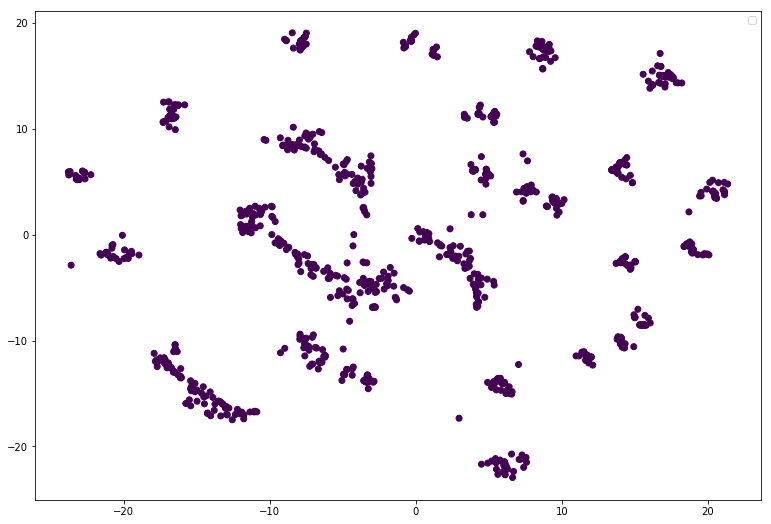

In [70]:
plt.figure(figsize=(13,9))
plt.scatter(tsne_data[:,0],tsne_data[:,1], c=coloring_list)
plt.legend(handles=patches)

### Compute and visualize the t-SNE projection of the rescaled data

In [71]:
tsne_data_rescaled = tsne.fit_transform(X_rescaled)

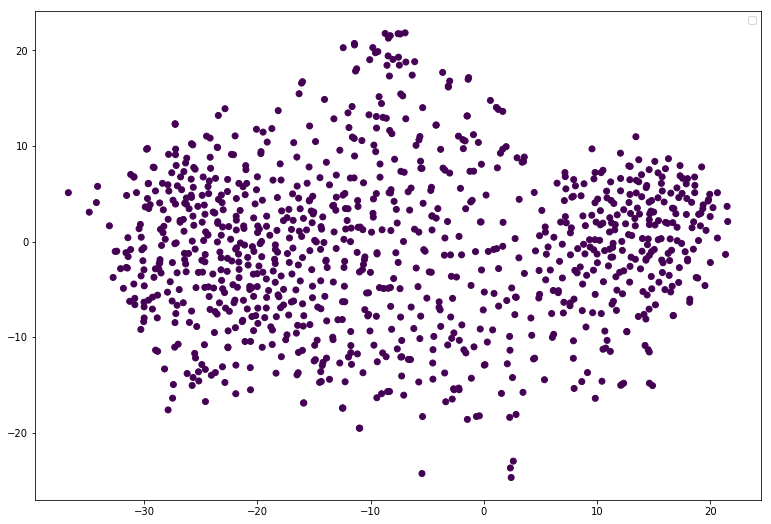

In [72]:
plt.figure(figsize=(13,9))
plt.scatter(tsne_data_rescaled[:,0],tsne_data_rescaled[:,1], c=coloring_list)
plt.legend(handles=patches)

### Compute and visualize the t-SNE projection of the PCA projected data

In [73]:
tsne_data_PCA = tsne.fit_transform(X_PCA)

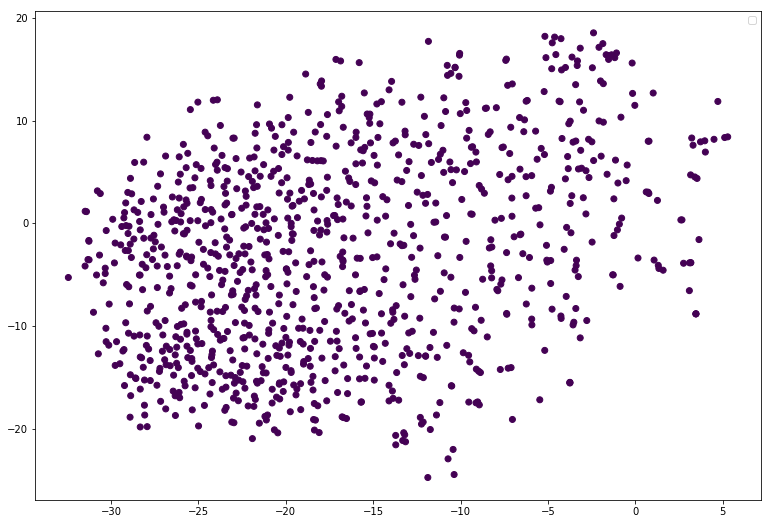

In [74]:
plt.figure(figsize=(13,9))
plt.scatter(tsne_data_PCA[:,0],tsne_data_PCA[:,1], c=coloring_list)
plt.legend(handles=patches)

### Advanced t-SNE usage

When using t-SNE as an exploratory technique, it is important to understand the most common pitfalls. You can read [Wattenberg, et al. “How to Use t-SNE Effectively”, Distill, 2016](http://distill.pub/2016/misread-tsne/) for more information.

We will use a list of different perplexity values to help you see if structure in your data is consistent. You can try with the raw data (X_df), rescaled data (X_std) or PCA transformed data (X_PCA).

In [75]:
perplexity_list = [5, 10, 30, 50, 100]
tsne_perp = [ TSNE(n_components=2, random_state=0, perplexity=perp) for perp in perplexity_list]
tsne_perp_data = [ tsne.fit_transform(X_df) for tsne in tsne_perp]

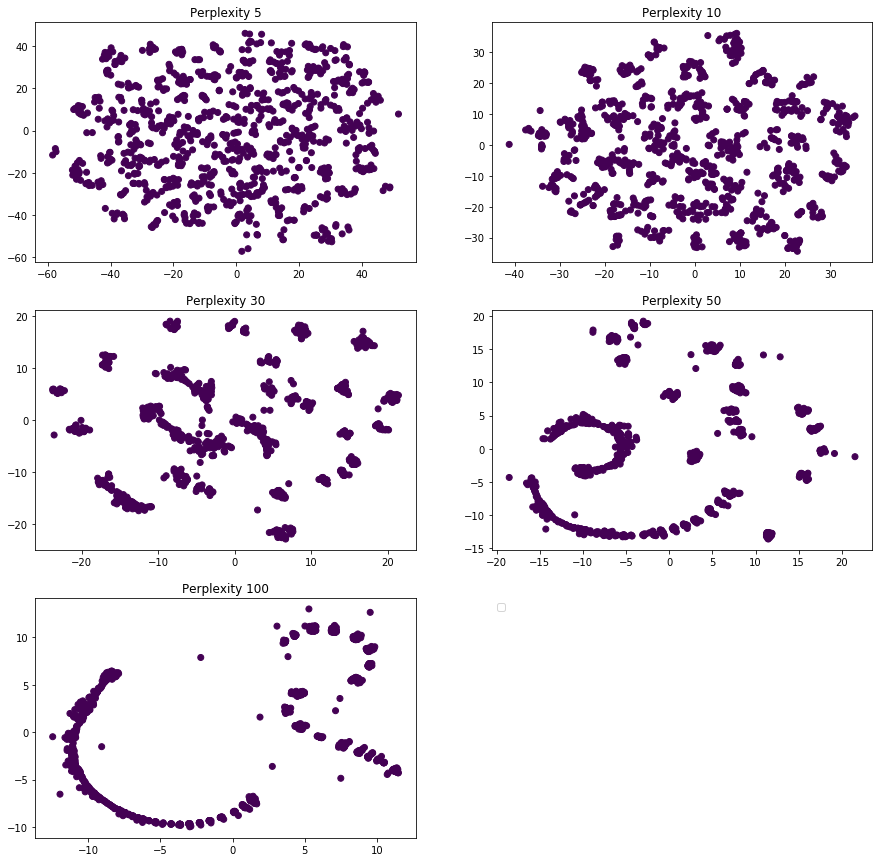

In [76]:
plt.figure(figsize=(15,15))
for i in range(len(perplexity_list)):
    plt.subplot(3,2, i+1)
    plt.title("Perplexity " + str(perplexity_list[i]))
    plt.scatter(tsne_perp_data[i][:,0],tsne_perp_data[i][:,1], c=coloring_list)
plt.subplot(3,2, i+2)
plt.axis('off')
plt.legend(handles=patches, loc='upper left')